## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD

## Load data and EDA

In [2]:
amazon_ratings = pd.read_csv('ratings_Beauty.csv')
amazon_ratings.head()

,UserId,ProductId,Rating,Timestamp
0,A39HTATAQ9V7YF,0205616461,5.0,1369699200
1,A3JM6GV9MNOF9X,0558925278,3.0,1355443200
2,A1Z513UWSAAO0F,0558925278,5.0,1404691200
3,A1WMRR494NWEWV,0733001998,4.0,1382572800
4,A3IAAVS479H7M7,0737104473,1.0,1274227200


In [3]:
print(amazon_ratings.isnull().sum()) #check for missing value

UserId       0
ProductId    0
Rating       0
Timestamp    0
dtype: int64


In [4]:
column_list = amazon_ratings.columns

for col in column_list:
    # unique_value = amazon_ratings[col].unique()
    unique_count = amazon_ratings[col].nunique()
    print(f"The number of unique values in column '{col}': {unique_count}")

The number of unique values in column 'UserId': 1210271
The number of unique values in column 'ProductId': 249274
The number of unique values in column 'Rating': 5
The number of unique values in column 'Timestamp': 4231


We have 5-scale rating. From naively looking at the number of each data, we can say that a single product can be bought from multiple users.

### User data analysis

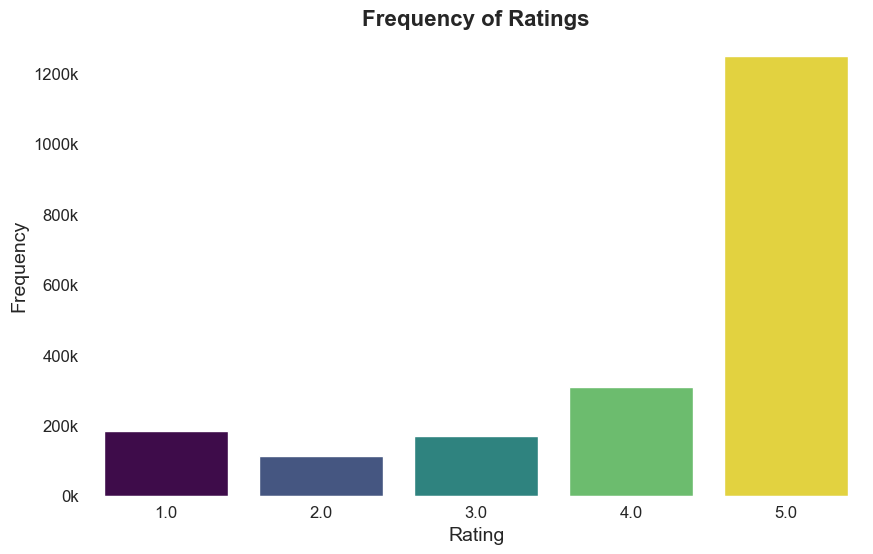

In [5]:
# Calculate the frequency of ratings
rating_counts = amazon_ratings['Rating'].value_counts().sort_index()

# Create a DataFrame from the rating counts
rating_df = rating_counts.reset_index()
rating_df.columns = ['Rating', 'Frequency']

# Create the bar chart using seaborn
plt.figure(figsize=(10, 6))
sns.barplot(data=rating_df, x='Rating', y='Frequency', hue='Rating', dodge=False, palette='viridis', legend=False)

# Customize the chart layout and style
plt.title('Frequency of Ratings', fontsize=16, fontweight='bold')
plt.xlabel('Rating', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# plt.grid(axis='y', linestyle='--', alpha=0.7)

# Set background to be transparent
plt.gca().patch.set_alpha(0)
plt.gcf().patch.set_alpha(0)

# plt.gca().yaxis.get_major_formatter().set_scientific(False)

# Adjust y-axis to display numbers in thousands
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x / 1000)}k'))


# Display the chart
plt.show()

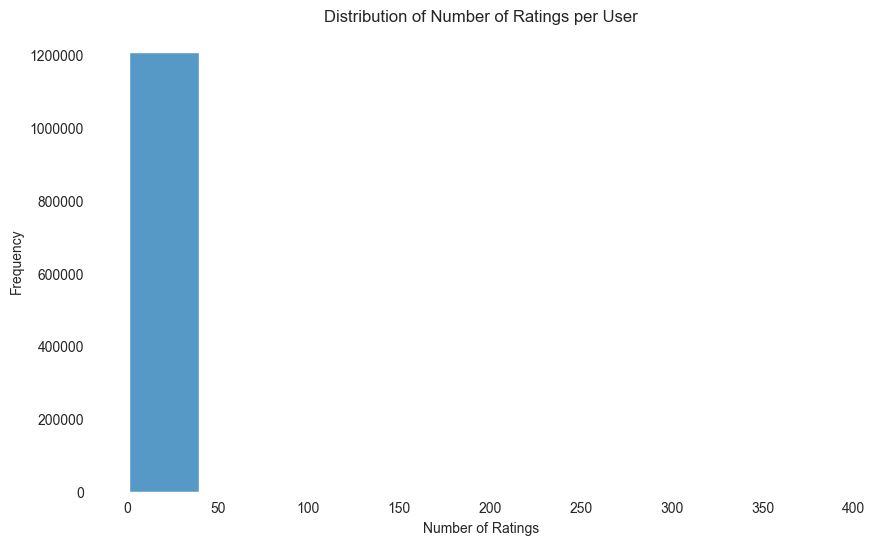

In [6]:
# Count of rating per user
user_rating_count = amazon_ratings.groupby('UserId')['Rating'].count()

plt.figure(figsize=(10, 6))
sns.histplot(user_rating_count, bins=10)
plt.title('Distribution of Number of Ratings per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Frequency')

# Set background to be transparent
plt.gca().patch.set_alpha(0)
plt.gcf().patch.set_alpha(0)

# Adjust y-axis to display numbers
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}'))


plt.show()



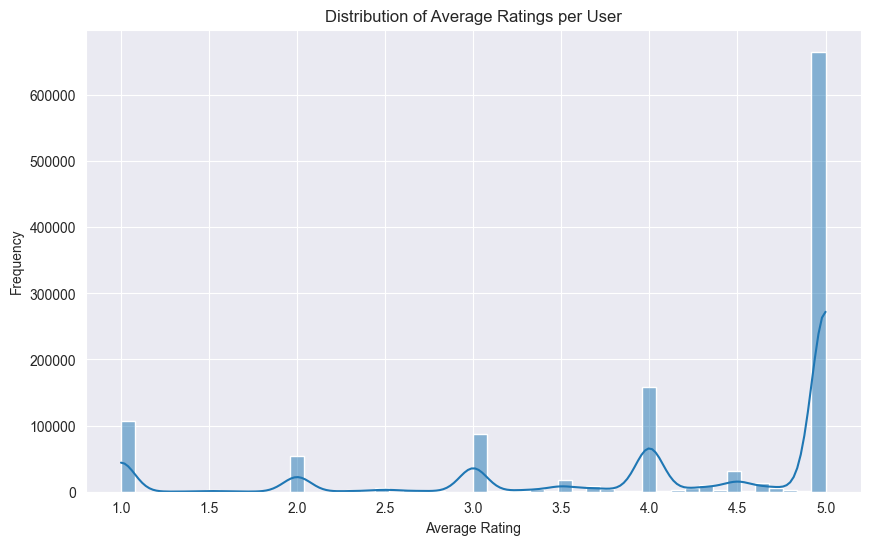

In [7]:
# average rating per user
user_avg_rating = amazon_ratings.groupby('UserId')['Rating'].mean()

plt.figure(figsize=(10, 6))
sns.histplot(user_avg_rating, bins=50, kde=True)
plt.title('Distribution of Average Ratings per User')
plt.xlabel('Average Rating')
plt.ylabel('Frequency')
plt.show()

**Data Skewness**: The high frequency of 5.0 ratings indicates data skewness, suggesting that users may not be providing thoughtful reviews.   
**Few Active Users**: Most ratings come from a few users, indicating that the data is dominated by a small number of users.   
**Rating Reliability**: The skewed data necessitates caution in recommendation system design, and additional measures may be required to ensure rating reliability.

### Product data analysis

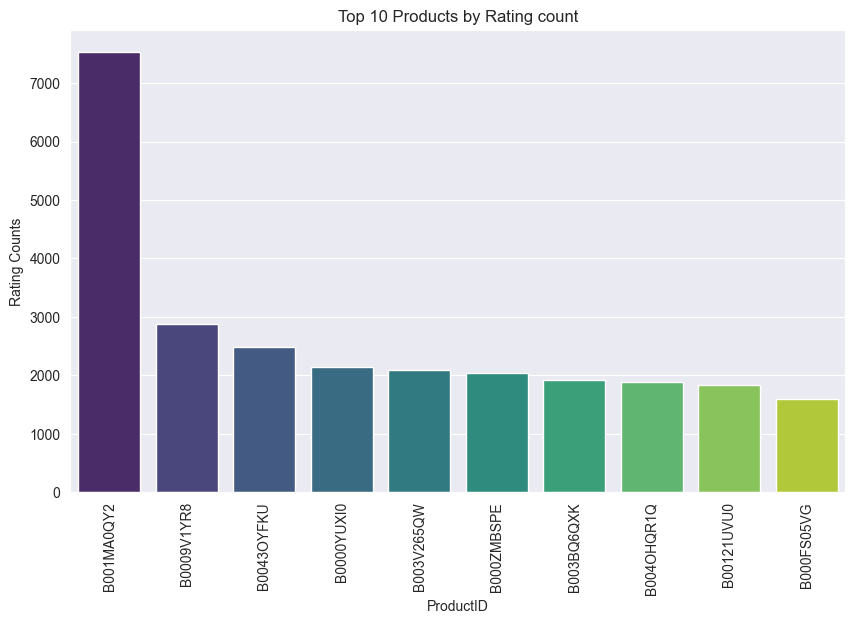

In [8]:
# Average ratings per product ID
product_rating_count = amazon_ratings.groupby('ProductId')['Rating'].count().sort_values(ascending=False)

top_10_products = product_rating_count.head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_10_products.index, y=top_10_products.values, hue =top_10_products.index, palette='viridis', legend=False)
plt.title('Top 10 Products by Rating count')
plt.xlabel('ProductID')
plt.ylabel('Rating Counts')
plt.xticks(rotation=90)
plt.show()

In [9]:
avg_rating_per_product = amazon_ratings.groupby('ProductId')['Rating'].mean().sort_values(ascending=False)
print(avg_rating_per_product)

ProductId
B00LPVG6V0    5.0
1304146537    5.0
B00LU0LTOU    5.0
0205616461    5.0
130414674X    5.0
             ... 
B001THZVBG    1.0
B001THQUPM    1.0
B00DQDZNE6    1.0
B00DQEBK06    1.0
957696718X    1.0
Name: Rating, Length: 249274, dtype: float64


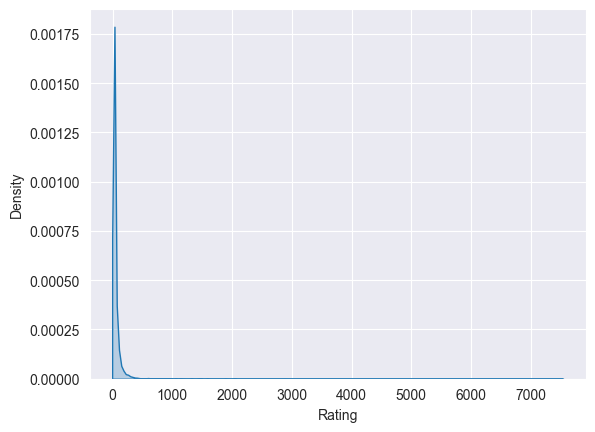

In [10]:
# Number of ratings per product KDE distribution
sns.kdeplot(product_rating_count, fill=True, cmap='viridis')
plt.show()

**Skewed Ratings Distribution**: One particular product has an exceptionally high number of ratings, with its count being more than twice that of the second most-rated product. This indicates that the rating data is skewed toward specific products. The KDE plot shows that the number of ratings is also skewed, meaning that most of the rating data in this dataset comes from a few products.   
**Rating Score vs. Review Count**: The product with the most reviews does not necessarily have the highest average rating.  

## Data preprocessing
In this step, we preprocess our data for input of the model. Following were done:
1. Drop timestamp, since in this dataset, it is not an important feature regarding ratings, i.e., opinion of a product is not effected by the timeframe.
2. Encode categorical variables such as UserId and ProductId
3. Split the data 3:7 ratio for test, train data

In [11]:
# Preprocess data : drop unnecessary data, encode categorical data
amazon_ratings=amazon_ratings.drop('Timestamp',axis=1)
le=LabelEncoder()
amazon_ratings['UserId']=le.fit_transform(amazon_ratings['UserId'])
amazon_ratings['ProductId']=le.fit_transform(amazon_ratings['ProductId'])


In [12]:
# Sample 10,000 data points due to resource limitation 
sample_data = amazon_ratings.sample(n = 10000, random_state=42)

# train_data, test_data = train_test_split(sample_data, test_size=0.3, random_state=42)

## Train model
In this project, the K-Nearest Neighbors (KNN) algorithm was selected due to its ability to handle sparse data effectively by focusing on similarity measures. KNN is particularly suitable for recommendation tasks because it can directly utilize the cosine similarity metric to find similar users or items, even in the presence of sparse data. This approach leverages user-item interactions to recommend items based on the similarity between users or items. The underlying assumption is that similar users tend to choose similar products.

Before training the model, a user-item interaction matrix is constructed and converted into a sparse matrix format, as not every user has interacted with every item. In this matrix, rows represent user IDs and columns represent products. Although item-based collaborative filtering can be performed by transposing this matrix, in this project, we used user-based collaborative filtering based on our assumption that similar users choose similar products.

In [13]:
# Create user-item interaction matrix
user_item_matrix = sample_data.pivot_table(index='UserId', columns='ProductId', values='Rating').fillna(0)

# Convert to sparse matrix
user_item_sparse_matrix = csr_matrix(user_item_matrix.values)
# 
# svd = TruncatedSVD(n_components=50)  # Adjust n_components as needed
# user_item_matrix_reduced = svd.fit_transform(user_item_sparse_matrix)


In [14]:
nearest_neighbors=NearestNeighbors(metric='cosine',algorithm='brute',n_neighbors=10)
nearest_neighbors.fit(user_item_sparse_matrix)

NearestNeighbors(algorithm='brute', metric='cosine', n_neighbors=10)

In [15]:
def recommend_products(userID, n_recommendation, nearest_neighbors, alpha=0.5):
    # Ensure the user exists in the matrix
    if userID not in user_item_matrix.index:
        print(f"No data found for UserID: {userID}")
        return pd.DataFrame()

    # Get the profile of the specified user from the user-item matrix
    user_profile = user_item_matrix.loc[userID].values.reshape(1, -1)  # Reshape to 2D array for kneighbors

    # Check if the user_profile is empty
    if user_profile.size == 0:
        print(f"No data available for UserID: {userID}")
        return pd.DataFrame()

    # Find similar users to the specified user
    try:
        distances, indices = nearest_neighbors.kneighbors(user_profile)
    except ValueError as e:
        print(f"Error finding neighbors for UserID {userID}: {e}")
        return pd.DataFrame()

    # Get the list of similar users
    similar_users = user_item_matrix.index[indices.flatten()]

    # Get products rated by similar users with weights based on distance
    weighted_ratings = []
    for i, user in enumerate(similar_users):
        user_ratings = amazon_ratings[amazon_ratings['UserId'] == user]
        weight = 1 / (distances.flatten()[i] + 1e-5)  # Avoid division by zero
        weighted_ratings.append(user_ratings.assign(Weight=weight))

    if not weighted_ratings:  # Check if no similar users found
        print(f"No similar users found for UserID: {userID}")
        return pd.DataFrame()

    weighted_ratings_df = pd.concat(weighted_ratings)

    # Explicitly select columns after groupby
    product_stats = weighted_ratings_df.groupby('ProductId').apply(
        lambda group: pd.Series({
            'Weighted_Average_Rating': np.average(group['Rating'], weights=group['Weight']),
            'Rating_Count': len(group)
        })
    ).reset_index()

    # Normalize the rating count
    if product_stats['Rating_Count'].max() != product_stats['Rating_Count'].min():  # Avoid division by zero
        product_stats['Normalized_Rating_Count'] = (
            (product_stats['Rating_Count'] - product_stats['Rating_Count'].min()) / 
            (product_stats['Rating_Count'].max() - product_stats['Rating_Count'].min())
        )
    else:
        product_stats['Normalized_Rating_Count'] = product_stats['Rating_Count']  # Handle case with all same counts

    # Calculate the weighted score
    product_stats['Weighted_Score'] = alpha * product_stats['Weighted_Average_Rating'] + (1 - alpha) * product_stats['Normalized_Rating_Count']

    # Get the top products based on the weighted score
    top_products = product_stats.nlargest(n_recommendation, 'Weighted_Score')

    # Convert product IDs back to original codes
    product_codes = le.inverse_transform(top_products['ProductId'])

    # Create a DataFrame with the recommended products and their scores
    recommendation_table = pd.DataFrame({
        'Product ID': top_products['ProductId'],
        'Product Code': product_codes,
        'Weighted Average Rating': top_products['Weighted_Average_Rating'],
        'Rating Count': top_products['Rating_Count'],
        'Weighted Score': top_products['Weighted_Score']
    }).set_index('Product ID')

    return recommendation_table


In [16]:
def evaluate_recommendations(test_user_item_matrix, nearest_neighbors, alpha=0.5, n_recommendation=10):
    precisions = []
    recalls = []


    for user_idx in range(test_user_item_matrix.shape[0]):

        recommendations = recommend_products(user_idx, n_recommendation, nearest_neighbors, alpha)
        
        if recommendations.empty:
            continue
        

        actual_ratings = test_user_item_matrix[user_idx].toarray().flatten()
        actual_items = set(np.where(actual_ratings > 0)[0])  # 실제로 평가된 제품들의 인덱스를 가져옵니다.
        
 
        recommended_items = set(recommendations.index)
        
        # compute precision and recall
        if recommended_items:
            precision = len(recommended_items & actual_items) / len(recommended_items)
        else:
            precision = 0
        
        if actual_items:
            recall = len(recommended_items & actual_items) / len(actual_items)
        else:
            recall = 0
        
        precisions.append(precision)
        recalls.append(recall)
    
    avg_precision = np.mean(precisions)
    avg_recall = np.mean(recalls)
    
    return avg_precision, avg_recall


## Evaluate Model

In [18]:
precision, recall = evaluate_recommendations(user_item_sparse_matrix, nearest_neighbors, alpha=0.5, n_recommendation=10)
print(f'Precision: {precision:.4f}, Recall: {recall:.4f}')

No data found for UserID: 0
No data found for UserID: 1
No data found for UserID: 2
No data found for UserID: 3
No data found for UserID: 4
No data found for UserID: 5
No data found for UserID: 6
No data found for UserID: 7
No data found for UserID: 8
No data found for UserID: 9
No data found for UserID: 10
No data found for UserID: 11
No data found for UserID: 12
No data found for UserID: 13
No data found for UserID: 14
No data found for UserID: 15
No data found for UserID: 16
No data found for UserID: 17
No data found for UserID: 18
No data found for UserID: 19
No data found for UserID: 20
No data found for UserID: 21
No data found for UserID: 22
No data found for UserID: 23
No data found for UserID: 24
No data found for UserID: 25
No data found for UserID: 26
No data found for UserID: 27
No data found for UserID: 28
No data found for UserID: 29
No data found for UserID: 30
No data found for UserID: 31
No data found for UserID: 32
No data found for UserID: 33
No data found for UserID

C:\Users\situj\AppData\Local\Temp\ipykernel_10624\829976847.py:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  product_stats = weighted_ratings_df.groupby('ProductId').apply(


No data found for UserID: 63
No data found for UserID: 64
No data found for UserID: 65
No data found for UserID: 66
No data found for UserID: 67
No data found for UserID: 68
No data found for UserID: 69
No data found for UserID: 70
No data found for UserID: 71
No data found for UserID: 72


C:\Users\situj\AppData\Local\Temp\ipykernel_10624\829976847.py:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  product_stats = weighted_ratings_df.groupby('ProductId').apply(
C:\Users\situj\AppData\Local\Temp\ipykernel_10624\829976847.py:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  product_stats = weighted_ratings_df.groupby('ProductId').apply(


No data found for UserID: 74
No data found for UserID: 75
No data found for UserID: 76
No data found for UserID: 77
No data found for UserID: 78
No data found for UserID: 79
No data found for UserID: 80
No data found for UserID: 81
No data found for UserID: 82
No data found for UserID: 83
No data found for UserID: 84
No data found for UserID: 85
No data found for UserID: 86
No data found for UserID: 88
No data found for UserID: 89
No data found for UserID: 90
No data found for UserID: 91
No data found for UserID: 92
No data found for UserID: 93
No data found for UserID: 94
No data found for UserID: 95
No data found for UserID: 96
No data found for UserID: 97
No data found for UserID: 98
No data found for UserID: 99
No data found for UserID: 100
No data found for UserID: 101
No data found for UserID: 102
No data found for UserID: 103
No data found for UserID: 104
No data found for UserID: 105
No data found for UserID: 106
No data found for UserID: 107
No data found for UserID: 108
No da

C:\Users\situj\AppData\Local\Temp\ipykernel_10624\829976847.py:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  product_stats = weighted_ratings_df.groupby('ProductId').apply(
C:\Users\situj\AppData\Local\Temp\ipykernel_10624\829976847.py:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  product_stats = weighted_ratings_df.groupby('ProductId').apply(


No data found for UserID: 190
No data found for UserID: 191
No data found for UserID: 192
No data found for UserID: 193
No data found for UserID: 194
No data found for UserID: 195
No data found for UserID: 196
No data found for UserID: 197
No data found for UserID: 198
No data found for UserID: 199
No data found for UserID: 200
No data found for UserID: 201
No data found for UserID: 202
No data found for UserID: 203
No data found for UserID: 204
No data found for UserID: 205
No data found for UserID: 207
No data found for UserID: 208
No data found for UserID: 209
No data found for UserID: 210
No data found for UserID: 211
No data found for UserID: 212
No data found for UserID: 213
No data found for UserID: 214
No data found for UserID: 215
No data found for UserID: 216
No data found for UserID: 217
No data found for UserID: 218
No data found for UserID: 219
No data found for UserID: 220
No data found for UserID: 221
No data found for UserID: 222
No data found for UserID: 223
No data fo

C:\Users\situj\AppData\Local\Temp\ipykernel_10624\829976847.py:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  product_stats = weighted_ratings_df.groupby('ProductId').apply(
C:\Users\situj\AppData\Local\Temp\ipykernel_10624\829976847.py:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  product_stats = weighted_ratings_df.groupby('ProductId').apply(


No data found for UserID: 562
No data found for UserID: 563
No data found for UserID: 564
No data found for UserID: 565
No data found for UserID: 566
No data found for UserID: 567
No data found for UserID: 568
No data found for UserID: 569
No data found for UserID: 570
No data found for UserID: 571
No data found for UserID: 572
No data found for UserID: 573
No data found for UserID: 574
No data found for UserID: 575
No data found for UserID: 576
No data found for UserID: 577
No data found for UserID: 578
No data found for UserID: 579
No data found for UserID: 580
No data found for UserID: 581
No data found for UserID: 582
No data found for UserID: 583
No data found for UserID: 584
No data found for UserID: 585
No data found for UserID: 586
No data found for UserID: 587
No data found for UserID: 588
No data found for UserID: 589
No data found for UserID: 590
No data found for UserID: 591
No data found for UserID: 592
No data found for UserID: 593
No data found for UserID: 594
No data fo

C:\Users\situj\AppData\Local\Temp\ipykernel_10624\829976847.py:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  product_stats = weighted_ratings_df.groupby('ProductId').apply(
C:\Users\situj\AppData\Local\Temp\ipykernel_10624\829976847.py:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  product_stats = weighted_ratings_df.groupby('ProductId').apply(


No data found for UserID: 1024
No data found for UserID: 1025
No data found for UserID: 1026
No data found for UserID: 1027
No data found for UserID: 1028
No data found for UserID: 1029
No data found for UserID: 1030
No data found for UserID: 1031
No data found for UserID: 1032
No data found for UserID: 1033
No data found for UserID: 1034
No data found for UserID: 1035
No data found for UserID: 1036
No data found for UserID: 1037
No data found for UserID: 1038
No data found for UserID: 1039
No data found for UserID: 1040
No data found for UserID: 1041
No data found for UserID: 1042
No data found for UserID: 1043
No data found for UserID: 1044
No data found for UserID: 1045
No data found for UserID: 1046
No data found for UserID: 1047
No data found for UserID: 1048
No data found for UserID: 1049
No data found for UserID: 1050
No data found for UserID: 1051
No data found for UserID: 1052
No data found for UserID: 1053
No data found for UserID: 1054
No data found for UserID: 1055
No data 

C:\Users\situj\AppData\Local\Temp\ipykernel_10624\829976847.py:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  product_stats = weighted_ratings_df.groupby('ProductId').apply(


No data found for UserID: 1455
No data found for UserID: 1456
No data found for UserID: 1457
No data found for UserID: 1458
No data found for UserID: 1459
No data found for UserID: 1460
No data found for UserID: 1461
No data found for UserID: 1462
No data found for UserID: 1463
No data found for UserID: 1464
No data found for UserID: 1465
No data found for UserID: 1466
No data found for UserID: 1467
No data found for UserID: 1468
No data found for UserID: 1469
No data found for UserID: 1470
No data found for UserID: 1471
No data found for UserID: 1472
No data found for UserID: 1473
No data found for UserID: 1474
No data found for UserID: 1475
No data found for UserID: 1476
No data found for UserID: 1477
No data found for UserID: 1478
No data found for UserID: 1479
No data found for UserID: 1480
No data found for UserID: 1481
No data found for UserID: 1482
No data found for UserID: 1483
No data found for UserID: 1484
No data found for UserID: 1485
No data found for UserID: 1486
No data 

C:\Users\situj\AppData\Local\Temp\ipykernel_10624\829976847.py:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  product_stats = weighted_ratings_df.groupby('ProductId').apply(
C:\Users\situj\AppData\Local\Temp\ipykernel_10624\829976847.py:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  product_stats = weighted_ratings_df.groupby('ProductId').apply(


No data found for UserID: 2199
No data found for UserID: 2200
No data found for UserID: 2201
No data found for UserID: 2202
No data found for UserID: 2203
No data found for UserID: 2204
No data found for UserID: 2205
No data found for UserID: 2206
No data found for UserID: 2207
No data found for UserID: 2208
No data found for UserID: 2209
No data found for UserID: 2210
No data found for UserID: 2211
No data found for UserID: 2212
No data found for UserID: 2213
No data found for UserID: 2214
No data found for UserID: 2215
No data found for UserID: 2216
No data found for UserID: 2217
No data found for UserID: 2218
No data found for UserID: 2219
No data found for UserID: 2220
No data found for UserID: 2221
No data found for UserID: 2222
No data found for UserID: 2223
No data found for UserID: 2224
No data found for UserID: 2225
No data found for UserID: 2226
No data found for UserID: 2228
No data found for UserID: 2229
No data found for UserID: 2230
No data found for UserID: 2231
No data 

C:\Users\situj\AppData\Local\Temp\ipykernel_10624\829976847.py:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  product_stats = weighted_ratings_df.groupby('ProductId').apply(
C:\Users\situj\AppData\Local\Temp\ipykernel_10624\829976847.py:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  product_stats = weighted_ratings_df.groupby('ProductId').apply(


No data found for UserID: 2408
No data found for UserID: 2409
No data found for UserID: 2410
No data found for UserID: 2411
No data found for UserID: 2412
No data found for UserID: 2413
No data found for UserID: 2414
No data found for UserID: 2415
No data found for UserID: 2416
No data found for UserID: 2417
No data found for UserID: 2418
No data found for UserID: 2419
No data found for UserID: 2420
No data found for UserID: 2421
No data found for UserID: 2422
No data found for UserID: 2423
No data found for UserID: 2424
No data found for UserID: 2426
No data found for UserID: 2427
No data found for UserID: 2428
No data found for UserID: 2429
No data found for UserID: 2430
No data found for UserID: 2431
No data found for UserID: 2432
No data found for UserID: 2433
No data found for UserID: 2434
No data found for UserID: 2435
No data found for UserID: 2436
No data found for UserID: 2437
No data found for UserID: 2438
No data found for UserID: 2439
No data found for UserID: 2440
No data 

C:\Users\situj\AppData\Local\Temp\ipykernel_10624\829976847.py:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  product_stats = weighted_ratings_df.groupby('ProductId').apply(
C:\Users\situj\AppData\Local\Temp\ipykernel_10624\829976847.py:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  product_stats = weighted_ratings_df.groupby('ProductId').apply(


No data found for UserID: 2480
No data found for UserID: 2481
No data found for UserID: 2482
No data found for UserID: 2483
No data found for UserID: 2484
No data found for UserID: 2485
No data found for UserID: 2486
No data found for UserID: 2487
No data found for UserID: 2488
No data found for UserID: 2489
No data found for UserID: 2490
No data found for UserID: 2491
No data found for UserID: 2492
No data found for UserID: 2493
No data found for UserID: 2494
No data found for UserID: 2495
No data found for UserID: 2496
No data found for UserID: 2497
No data found for UserID: 2498
No data found for UserID: 2499
No data found for UserID: 2500
No data found for UserID: 2501
No data found for UserID: 2502
No data found for UserID: 2503
No data found for UserID: 2504
No data found for UserID: 2505
No data found for UserID: 2506
No data found for UserID: 2507
No data found for UserID: 2508
No data found for UserID: 2509
No data found for UserID: 2510
No data found for UserID: 2511
No data 

C:\Users\situj\AppData\Local\Temp\ipykernel_10624\829976847.py:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  product_stats = weighted_ratings_df.groupby('ProductId').apply(


No data found for UserID: 2603
No data found for UserID: 2604
No data found for UserID: 2605
No data found for UserID: 2606
No data found for UserID: 2607
No data found for UserID: 2608
No data found for UserID: 2609
No data found for UserID: 2610
No data found for UserID: 2611
No data found for UserID: 2612
No data found for UserID: 2613
No data found for UserID: 2614
No data found for UserID: 2615
No data found for UserID: 2616
No data found for UserID: 2617
No data found for UserID: 2618
No data found for UserID: 2619
No data found for UserID: 2620
No data found for UserID: 2621
No data found for UserID: 2622
No data found for UserID: 2623
No data found for UserID: 2624
No data found for UserID: 2625
No data found for UserID: 2626
No data found for UserID: 2627
No data found for UserID: 2628
No data found for UserID: 2629
No data found for UserID: 2630
No data found for UserID: 2631
No data found for UserID: 2632
No data found for UserID: 2633
No data found for UserID: 2634
No data 

C:\Users\situj\AppData\Local\Temp\ipykernel_10624\829976847.py:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  product_stats = weighted_ratings_df.groupby('ProductId').apply(
C:\Users\situj\AppData\Local\Temp\ipykernel_10624\829976847.py:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  product_stats = weighted_ratings_df.groupby('ProductId').apply(


No data found for UserID: 2709
No data found for UserID: 2710
No data found for UserID: 2711
No data found for UserID: 2712
No data found for UserID: 2713
No data found for UserID: 2714
No data found for UserID: 2715
No data found for UserID: 2716
No data found for UserID: 2717
No data found for UserID: 2718
No data found for UserID: 2719
No data found for UserID: 2720
No data found for UserID: 2721
No data found for UserID: 2722
No data found for UserID: 2723
No data found for UserID: 2724
No data found for UserID: 2725
No data found for UserID: 2726
No data found for UserID: 2727
No data found for UserID: 2728
No data found for UserID: 2729
No data found for UserID: 2730
No data found for UserID: 2731
No data found for UserID: 2732
No data found for UserID: 2733
No data found for UserID: 2734
No data found for UserID: 2735
No data found for UserID: 2736
No data found for UserID: 2737
No data found for UserID: 2738
No data found for UserID: 2739
No data found for UserID: 2740
No data 

C:\Users\situj\AppData\Local\Temp\ipykernel_10624\829976847.py:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  product_stats = weighted_ratings_df.groupby('ProductId').apply(


No data found for UserID: 2764
No data found for UserID: 2765
No data found for UserID: 2766
No data found for UserID: 2767
No data found for UserID: 2768
No data found for UserID: 2769
No data found for UserID: 2770
No data found for UserID: 2771
No data found for UserID: 2772
No data found for UserID: 2773
No data found for UserID: 2774
No data found for UserID: 2775
No data found for UserID: 2776
No data found for UserID: 2777
No data found for UserID: 2778
No data found for UserID: 2779
No data found for UserID: 2780
No data found for UserID: 2781
No data found for UserID: 2782
No data found for UserID: 2783
No data found for UserID: 2784
No data found for UserID: 2785
No data found for UserID: 2786
No data found for UserID: 2787
No data found for UserID: 2788
No data found for UserID: 2789
No data found for UserID: 2790
No data found for UserID: 2791
No data found for UserID: 2792
No data found for UserID: 2793
No data found for UserID: 2794
No data found for UserID: 2795
No data 

C:\Users\situj\AppData\Local\Temp\ipykernel_10624\829976847.py:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  product_stats = weighted_ratings_df.groupby('ProductId').apply(
C:\Users\situj\AppData\Local\Temp\ipykernel_10624\829976847.py:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  product_stats = weighted_ratings_df.groupby('ProductId').apply(


No data found for UserID: 3153
No data found for UserID: 3154
No data found for UserID: 3155
No data found for UserID: 3156
No data found for UserID: 3157
No data found for UserID: 3158
No data found for UserID: 3159
No data found for UserID: 3160
No data found for UserID: 3161
No data found for UserID: 3162
No data found for UserID: 3163
No data found for UserID: 3164
No data found for UserID: 3165
No data found for UserID: 3166
No data found for UserID: 3167
No data found for UserID: 3168
No data found for UserID: 3169
No data found for UserID: 3170
No data found for UserID: 3171
No data found for UserID: 3172
No data found for UserID: 3173
No data found for UserID: 3174
No data found for UserID: 3175
No data found for UserID: 3176
No data found for UserID: 3177
No data found for UserID: 3178
No data found for UserID: 3179
No data found for UserID: 3180
No data found for UserID: 3181
No data found for UserID: 3182
No data found for UserID: 3183
No data found for UserID: 3184
No data 

C:\Users\situj\AppData\Local\Temp\ipykernel_10624\829976847.py:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  product_stats = weighted_ratings_df.groupby('ProductId').apply(
C:\Users\situj\AppData\Local\Temp\ipykernel_10624\829976847.py:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  product_stats = weighted_ratings_df.groupby('ProductId').apply(


No data found for UserID: 3353
No data found for UserID: 3354
No data found for UserID: 3355
No data found for UserID: 3356
No data found for UserID: 3357
No data found for UserID: 3358
No data found for UserID: 3359
No data found for UserID: 3360
No data found for UserID: 3361
No data found for UserID: 3362
No data found for UserID: 3363
No data found for UserID: 3364
No data found for UserID: 3365
No data found for UserID: 3366
No data found for UserID: 3367
No data found for UserID: 3368
No data found for UserID: 3369
No data found for UserID: 3370
No data found for UserID: 3371
No data found for UserID: 3372
No data found for UserID: 3373
No data found for UserID: 3374
No data found for UserID: 3375
No data found for UserID: 3376
No data found for UserID: 3377
No data found for UserID: 3378
No data found for UserID: 3379
No data found for UserID: 3380
No data found for UserID: 3381
No data found for UserID: 3382
No data found for UserID: 3383
No data found for UserID: 3384
No data 

C:\Users\situj\AppData\Local\Temp\ipykernel_10624\829976847.py:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  product_stats = weighted_ratings_df.groupby('ProductId').apply(


No data found for UserID: 3572
No data found for UserID: 3573
No data found for UserID: 3574
No data found for UserID: 3575
No data found for UserID: 3576
No data found for UserID: 3577
No data found for UserID: 3578
No data found for UserID: 3579
No data found for UserID: 3580
No data found for UserID: 3581
No data found for UserID: 3582
No data found for UserID: 3583
No data found for UserID: 3584
No data found for UserID: 3585
No data found for UserID: 3586
No data found for UserID: 3587
No data found for UserID: 3588
No data found for UserID: 3589
No data found for UserID: 3590
No data found for UserID: 3591
No data found for UserID: 3592
No data found for UserID: 3593
No data found for UserID: 3594
No data found for UserID: 3595
No data found for UserID: 3596
No data found for UserID: 3597
No data found for UserID: 3598
No data found for UserID: 3599
No data found for UserID: 3600
No data found for UserID: 3601
No data found for UserID: 3602
No data found for UserID: 3603
No data 

C:\Users\situj\AppData\Local\Temp\ipykernel_10624\829976847.py:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  product_stats = weighted_ratings_df.groupby('ProductId').apply(
C:\Users\situj\AppData\Local\Temp\ipykernel_10624\829976847.py:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  product_stats = weighted_ratings_df.groupby('ProductId').apply(


No data found for UserID: 3939
No data found for UserID: 3940
No data found for UserID: 3941
No data found for UserID: 3942
No data found for UserID: 3943
No data found for UserID: 3944
No data found for UserID: 3945
No data found for UserID: 3946
No data found for UserID: 3947
No data found for UserID: 3948
No data found for UserID: 3949
No data found for UserID: 3950
No data found for UserID: 3951
No data found for UserID: 3952
No data found for UserID: 3953
No data found for UserID: 3954
No data found for UserID: 3955
No data found for UserID: 3956
No data found for UserID: 3957
No data found for UserID: 3958
No data found for UserID: 3959
No data found for UserID: 3960
No data found for UserID: 3961
No data found for UserID: 3962
No data found for UserID: 3963
No data found for UserID: 3964
No data found for UserID: 3965
No data found for UserID: 3966
No data found for UserID: 3967
No data found for UserID: 3968
No data found for UserID: 3969
No data found for UserID: 3970
No data 

C:\Users\situj\AppData\Local\Temp\ipykernel_10624\829976847.py:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  product_stats = weighted_ratings_df.groupby('ProductId').apply(
C:\Users\situj\AppData\Local\Temp\ipykernel_10624\829976847.py:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  product_stats = weighted_ratings_df.groupby('ProductId').apply(


No data found for UserID: 4118
No data found for UserID: 4119
No data found for UserID: 4120
No data found for UserID: 4121
No data found for UserID: 4122
No data found for UserID: 4123
No data found for UserID: 4124
No data found for UserID: 4125
No data found for UserID: 4126
No data found for UserID: 4127
No data found for UserID: 4128
No data found for UserID: 4129
No data found for UserID: 4130
No data found for UserID: 4131
No data found for UserID: 4132
No data found for UserID: 4133
No data found for UserID: 4134
No data found for UserID: 4135
No data found for UserID: 4136
No data found for UserID: 4137
No data found for UserID: 4138
No data found for UserID: 4139
No data found for UserID: 4140
No data found for UserID: 4141
No data found for UserID: 4142
No data found for UserID: 4143
No data found for UserID: 4144
No data found for UserID: 4145
No data found for UserID: 4146
No data found for UserID: 4147
No data found for UserID: 4148
No data found for UserID: 4149
No data 

C:\Users\situj\AppData\Local\Temp\ipykernel_10624\829976847.py:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  product_stats = weighted_ratings_df.groupby('ProductId').apply(
C:\Users\situj\AppData\Local\Temp\ipykernel_10624\829976847.py:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  product_stats = weighted_ratings_df.groupby('ProductId').apply(


No data found for UserID: 4538
No data found for UserID: 4539
No data found for UserID: 4540
No data found for UserID: 4541
No data found for UserID: 4542
No data found for UserID: 4543
No data found for UserID: 4544
No data found for UserID: 4545
No data found for UserID: 4546
No data found for UserID: 4547
No data found for UserID: 4548
No data found for UserID: 4549
No data found for UserID: 4550
No data found for UserID: 4551
No data found for UserID: 4552
No data found for UserID: 4553
No data found for UserID: 4554
No data found for UserID: 4555
No data found for UserID: 4556
No data found for UserID: 4557
No data found for UserID: 4558
No data found for UserID: 4559
No data found for UserID: 4560
No data found for UserID: 4561
No data found for UserID: 4562
No data found for UserID: 4563
No data found for UserID: 4564
No data found for UserID: 4565
No data found for UserID: 4566
No data found for UserID: 4567
No data found for UserID: 4568
No data found for UserID: 4569
No data 

C:\Users\situj\AppData\Local\Temp\ipykernel_10624\829976847.py:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  product_stats = weighted_ratings_df.groupby('ProductId').apply(
C:\Users\situj\AppData\Local\Temp\ipykernel_10624\829976847.py:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  product_stats = weighted_ratings_df.groupby('ProductId').apply(


No data found for UserID: 4608
No data found for UserID: 4609
No data found for UserID: 4610
No data found for UserID: 4611
No data found for UserID: 4612
No data found for UserID: 4613
No data found for UserID: 4614
No data found for UserID: 4615
No data found for UserID: 4616
No data found for UserID: 4617
No data found for UserID: 4618
No data found for UserID: 4619
No data found for UserID: 4620
No data found for UserID: 4621
No data found for UserID: 4622
No data found for UserID: 4623
No data found for UserID: 4624
No data found for UserID: 4625
No data found for UserID: 4626
No data found for UserID: 4627
No data found for UserID: 4628
No data found for UserID: 4629
No data found for UserID: 4630
No data found for UserID: 4631
No data found for UserID: 4632
No data found for UserID: 4633
No data found for UserID: 4634
No data found for UserID: 4635
No data found for UserID: 4636
No data found for UserID: 4637
No data found for UserID: 4639
No data found for UserID: 4640
No data 

C:\Users\situj\AppData\Local\Temp\ipykernel_10624\829976847.py:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  product_stats = weighted_ratings_df.groupby('ProductId').apply(
C:\Users\situj\AppData\Local\Temp\ipykernel_10624\829976847.py:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  product_stats = weighted_ratings_df.groupby('ProductId').apply(


No data found for UserID: 4804
No data found for UserID: 4805
No data found for UserID: 4806
No data found for UserID: 4807
No data found for UserID: 4808
No data found for UserID: 4809
No data found for UserID: 4810
No data found for UserID: 4811
No data found for UserID: 4812
No data found for UserID: 4813
No data found for UserID: 4814
No data found for UserID: 4815
No data found for UserID: 4816
No data found for UserID: 4817
No data found for UserID: 4818
No data found for UserID: 4819
No data found for UserID: 4820
No data found for UserID: 4821
No data found for UserID: 4822
No data found for UserID: 4823
No data found for UserID: 4824
No data found for UserID: 4825
No data found for UserID: 4826
No data found for UserID: 4827
No data found for UserID: 4828
No data found for UserID: 4829
No data found for UserID: 4830
No data found for UserID: 4831
No data found for UserID: 4832
No data found for UserID: 4833
No data found for UserID: 4834
No data found for UserID: 4835
No data 

C:\Users\situj\AppData\Local\Temp\ipykernel_10624\829976847.py:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  product_stats = weighted_ratings_df.groupby('ProductId').apply(
C:\Users\situj\AppData\Local\Temp\ipykernel_10624\829976847.py:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  product_stats = weighted_ratings_df.groupby('ProductId').apply(


No data found for UserID: 4906
No data found for UserID: 4907
No data found for UserID: 4908
No data found for UserID: 4909
No data found for UserID: 4910
No data found for UserID: 4911
No data found for UserID: 4912
No data found for UserID: 4913
No data found for UserID: 4914
No data found for UserID: 4915
No data found for UserID: 4916
No data found for UserID: 4917
No data found for UserID: 4918
No data found for UserID: 4919
No data found for UserID: 4920
No data found for UserID: 4921
No data found for UserID: 4922
No data found for UserID: 4923
No data found for UserID: 4924
No data found for UserID: 4925
No data found for UserID: 4926
No data found for UserID: 4927
No data found for UserID: 4928
No data found for UserID: 4929
No data found for UserID: 4930
No data found for UserID: 4931
No data found for UserID: 4932
No data found for UserID: 4933
No data found for UserID: 4934
No data found for UserID: 4935
No data found for UserID: 4936
No data found for UserID: 4937
No data 

C:\Users\situj\AppData\Local\Temp\ipykernel_10624\829976847.py:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  product_stats = weighted_ratings_df.groupby('ProductId').apply(
C:\Users\situj\AppData\Local\Temp\ipykernel_10624\829976847.py:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  product_stats = weighted_ratings_df.groupby('ProductId').apply(


No data found for UserID: 5180
No data found for UserID: 5181
No data found for UserID: 5182
No data found for UserID: 5183
No data found for UserID: 5184
No data found for UserID: 5185
No data found for UserID: 5186
No data found for UserID: 5187
No data found for UserID: 5188
No data found for UserID: 5189
No data found for UserID: 5190
No data found for UserID: 5191
No data found for UserID: 5192
No data found for UserID: 5193
No data found for UserID: 5194
No data found for UserID: 5195
No data found for UserID: 5196
No data found for UserID: 5197
No data found for UserID: 5198
No data found for UserID: 5199
No data found for UserID: 5200
No data found for UserID: 5201
No data found for UserID: 5202
No data found for UserID: 5203
No data found for UserID: 5204
No data found for UserID: 5205
No data found for UserID: 5206
No data found for UserID: 5207
No data found for UserID: 5208
No data found for UserID: 5209
No data found for UserID: 5210
No data found for UserID: 5211
No data 

C:\Users\situj\AppData\Local\Temp\ipykernel_10624\829976847.py:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  product_stats = weighted_ratings_df.groupby('ProductId').apply(


No data found for UserID: 5416
No data found for UserID: 5417
No data found for UserID: 5418
No data found for UserID: 5419
No data found for UserID: 5420
No data found for UserID: 5421
No data found for UserID: 5422
No data found for UserID: 5423
No data found for UserID: 5424
No data found for UserID: 5425
No data found for UserID: 5426
No data found for UserID: 5427
No data found for UserID: 5428
No data found for UserID: 5429
No data found for UserID: 5430
No data found for UserID: 5431
No data found for UserID: 5432
No data found for UserID: 5433
No data found for UserID: 5434
No data found for UserID: 5435
No data found for UserID: 5436
No data found for UserID: 5437
No data found for UserID: 5438
No data found for UserID: 5439
No data found for UserID: 5440
No data found for UserID: 5441
No data found for UserID: 5442
No data found for UserID: 5443
No data found for UserID: 5444
No data found for UserID: 5445
No data found for UserID: 5446
No data found for UserID: 5447
No data 

C:\Users\situj\AppData\Local\Temp\ipykernel_10624\829976847.py:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  product_stats = weighted_ratings_df.groupby('ProductId').apply(
C:\Users\situj\AppData\Local\Temp\ipykernel_10624\829976847.py:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  product_stats = weighted_ratings_df.groupby('ProductId').apply(


No data found for UserID: 5497
No data found for UserID: 5498
No data found for UserID: 5499
No data found for UserID: 5500
No data found for UserID: 5501
No data found for UserID: 5502
No data found for UserID: 5503
No data found for UserID: 5504
No data found for UserID: 5505
No data found for UserID: 5506
No data found for UserID: 5507
No data found for UserID: 5508
No data found for UserID: 5509
No data found for UserID: 5510
No data found for UserID: 5511
No data found for UserID: 5512
No data found for UserID: 5513
No data found for UserID: 5514
No data found for UserID: 5515
No data found for UserID: 5516
No data found for UserID: 5517
No data found for UserID: 5518
No data found for UserID: 5519
No data found for UserID: 5520
No data found for UserID: 5521
No data found for UserID: 5522
No data found for UserID: 5523
No data found for UserID: 5524
No data found for UserID: 5525
No data found for UserID: 5526
No data found for UserID: 5527
No data found for UserID: 5528
No data 

C:\Users\situj\AppData\Local\Temp\ipykernel_10624\829976847.py:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  product_stats = weighted_ratings_df.groupby('ProductId').apply(
C:\Users\situj\AppData\Local\Temp\ipykernel_10624\829976847.py:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  product_stats = weighted_ratings_df.groupby('ProductId').apply(


No data found for UserID: 5603
No data found for UserID: 5604
No data found for UserID: 5605
No data found for UserID: 5606
No data found for UserID: 5607
No data found for UserID: 5608
No data found for UserID: 5609
No data found for UserID: 5610
No data found for UserID: 5611
No data found for UserID: 5612
No data found for UserID: 5613
No data found for UserID: 5614
No data found for UserID: 5615
No data found for UserID: 5616
No data found for UserID: 5617
No data found for UserID: 5618
No data found for UserID: 5619
No data found for UserID: 5620
No data found for UserID: 5621
No data found for UserID: 5622
No data found for UserID: 5623
No data found for UserID: 5624
No data found for UserID: 5625
No data found for UserID: 5626
No data found for UserID: 5627
No data found for UserID: 5628
No data found for UserID: 5629
No data found for UserID: 5630
No data found for UserID: 5631
No data found for UserID: 5632
No data found for UserID: 5633
No data found for UserID: 5634
No data 

C:\Users\situj\AppData\Local\Temp\ipykernel_10624\829976847.py:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  product_stats = weighted_ratings_df.groupby('ProductId').apply(
C:\Users\situj\AppData\Local\Temp\ipykernel_10624\829976847.py:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  product_stats = weighted_ratings_df.groupby('ProductId').apply(
C:\Users\situj\AppData\Local\Temp\ipykernel_10624\829976

No data found for UserID: 5838
No data found for UserID: 5839
No data found for UserID: 5840
No data found for UserID: 5841
No data found for UserID: 5842
No data found for UserID: 5843
No data found for UserID: 5844
No data found for UserID: 5845
No data found for UserID: 5846
No data found for UserID: 5847
No data found for UserID: 5848
No data found for UserID: 5849
No data found for UserID: 5850
No data found for UserID: 5851
No data found for UserID: 5852
No data found for UserID: 5853
No data found for UserID: 5854
No data found for UserID: 5855
No data found for UserID: 5856
No data found for UserID: 5857
No data found for UserID: 5858
No data found for UserID: 5859
No data found for UserID: 5860
No data found for UserID: 5861
No data found for UserID: 5862
No data found for UserID: 5863
No data found for UserID: 5864
No data found for UserID: 5865
No data found for UserID: 5866
No data found for UserID: 5867
No data found for UserID: 5868
No data found for UserID: 5869
No data 

C:\Users\situj\AppData\Local\Temp\ipykernel_10624\829976847.py:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  product_stats = weighted_ratings_df.groupby('ProductId').apply(
C:\Users\situj\AppData\Local\Temp\ipykernel_10624\829976847.py:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  product_stats = weighted_ratings_df.groupby('ProductId').apply(
C:\Users\situj\AppData\Local\Temp\ipykernel_10624\829976

No data found for UserID: 6083
No data found for UserID: 6084
No data found for UserID: 6085
No data found for UserID: 6086
No data found for UserID: 6087
No data found for UserID: 6088
No data found for UserID: 6089
No data found for UserID: 6090
No data found for UserID: 6091
No data found for UserID: 6092
No data found for UserID: 6093
No data found for UserID: 6094
No data found for UserID: 6095
No data found for UserID: 6096
No data found for UserID: 6097
No data found for UserID: 6098
No data found for UserID: 6099
No data found for UserID: 6100
No data found for UserID: 6101
No data found for UserID: 6102
No data found for UserID: 6103
No data found for UserID: 6104
No data found for UserID: 6105
No data found for UserID: 6106
No data found for UserID: 6107
No data found for UserID: 6108
No data found for UserID: 6109
No data found for UserID: 6110
No data found for UserID: 6111
No data found for UserID: 6112
No data found for UserID: 6113
No data found for UserID: 6114
No data 

C:\Users\situj\AppData\Local\Temp\ipykernel_10624\829976847.py:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  product_stats = weighted_ratings_df.groupby('ProductId').apply(
C:\Users\situj\AppData\Local\Temp\ipykernel_10624\829976847.py:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  product_stats = weighted_ratings_df.groupby('ProductId').apply(


No data found for UserID: 6389
No data found for UserID: 6390
No data found for UserID: 6391
No data found for UserID: 6392
No data found for UserID: 6393
No data found for UserID: 6394
No data found for UserID: 6395
No data found for UserID: 6396
No data found for UserID: 6397
No data found for UserID: 6398
No data found for UserID: 6399
No data found for UserID: 6400
No data found for UserID: 6401
No data found for UserID: 6402
No data found for UserID: 6403
No data found for UserID: 6404
No data found for UserID: 6405
No data found for UserID: 6406
No data found for UserID: 6407
No data found for UserID: 6408
No data found for UserID: 6409
No data found for UserID: 6410
No data found for UserID: 6411
No data found for UserID: 6412
No data found for UserID: 6413
No data found for UserID: 6414
No data found for UserID: 6415
No data found for UserID: 6416
No data found for UserID: 6417
No data found for UserID: 6418
No data found for UserID: 6419
No data found for UserID: 6420
No data 

C:\Users\situj\AppData\Local\Temp\ipykernel_10624\829976847.py:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  product_stats = weighted_ratings_df.groupby('ProductId').apply(
C:\Users\situj\AppData\Local\Temp\ipykernel_10624\829976847.py:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  product_stats = weighted_ratings_df.groupby('ProductId').apply(


No data found for UserID: 6613
No data found for UserID: 6614
No data found for UserID: 6615
No data found for UserID: 6616
No data found for UserID: 6617
No data found for UserID: 6618
No data found for UserID: 6619
No data found for UserID: 6620
No data found for UserID: 6621
No data found for UserID: 6622
No data found for UserID: 6623
No data found for UserID: 6624
No data found for UserID: 6625
No data found for UserID: 6626
No data found for UserID: 6627
No data found for UserID: 6628
No data found for UserID: 6629
No data found for UserID: 6630
No data found for UserID: 6631
No data found for UserID: 6632
No data found for UserID: 6633
No data found for UserID: 6634
No data found for UserID: 6635
No data found for UserID: 6636
No data found for UserID: 6637
No data found for UserID: 6638
No data found for UserID: 6639
No data found for UserID: 6640
No data found for UserID: 6641
No data found for UserID: 6642
No data found for UserID: 6643
No data found for UserID: 6644
No data 

C:\Users\situj\AppData\Local\Temp\ipykernel_10624\829976847.py:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  product_stats = weighted_ratings_df.groupby('ProductId').apply(
C:\Users\situj\AppData\Local\Temp\ipykernel_10624\829976847.py:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  product_stats = weighted_ratings_df.groupby('ProductId').apply(


No data found for UserID: 7436
No data found for UserID: 7437
No data found for UserID: 7438
No data found for UserID: 7439
No data found for UserID: 7440
No data found for UserID: 7441
No data found for UserID: 7442
No data found for UserID: 7443
No data found for UserID: 7444
No data found for UserID: 7445
No data found for UserID: 7446
No data found for UserID: 7447
No data found for UserID: 7448
No data found for UserID: 7449
No data found for UserID: 7450
No data found for UserID: 7451
No data found for UserID: 7452
No data found for UserID: 7453
No data found for UserID: 7454
No data found for UserID: 7455
No data found for UserID: 7456
No data found for UserID: 7457
No data found for UserID: 7458
No data found for UserID: 7459
No data found for UserID: 7460
No data found for UserID: 7461
No data found for UserID: 7462
No data found for UserID: 7463
No data found for UserID: 7464
No data found for UserID: 7465
No data found for UserID: 7466
No data found for UserID: 7467
No data 

C:\Users\situj\AppData\Local\Temp\ipykernel_10624\829976847.py:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  product_stats = weighted_ratings_df.groupby('ProductId').apply(
C:\Users\situj\AppData\Local\Temp\ipykernel_10624\829976847.py:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  product_stats = weighted_ratings_df.groupby('ProductId').apply(
C:\Users\situj\AppData\Local\Temp\ipykernel_10624\829976

No data found for UserID: 7707
No data found for UserID: 7708
No data found for UserID: 7709
No data found for UserID: 7710
No data found for UserID: 7711
No data found for UserID: 7712
No data found for UserID: 7713
No data found for UserID: 7714
No data found for UserID: 7715
No data found for UserID: 7716
No data found for UserID: 7717
No data found for UserID: 7718
No data found for UserID: 7719
No data found for UserID: 7720
No data found for UserID: 7721
No data found for UserID: 7722
No data found for UserID: 7723
No data found for UserID: 7724
No data found for UserID: 7725
No data found for UserID: 7726
No data found for UserID: 7727
No data found for UserID: 7728
No data found for UserID: 7729
No data found for UserID: 7730
No data found for UserID: 7731
No data found for UserID: 7732
No data found for UserID: 7733
No data found for UserID: 7734
No data found for UserID: 7735
No data found for UserID: 7736
No data found for UserID: 7737
No data found for UserID: 7738
No data 

C:\Users\situj\AppData\Local\Temp\ipykernel_10624\829976847.py:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  product_stats = weighted_ratings_df.groupby('ProductId').apply(
C:\Users\situj\AppData\Local\Temp\ipykernel_10624\829976847.py:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  product_stats = weighted_ratings_df.groupby('ProductId').apply(
C:\Users\situj\AppData\Local\Temp\ipykernel_10624\829976

No data found for UserID: 7971
No data found for UserID: 7972
No data found for UserID: 7973
No data found for UserID: 7974
No data found for UserID: 7975
No data found for UserID: 7976
No data found for UserID: 7977
No data found for UserID: 7978
No data found for UserID: 7979
No data found for UserID: 7980
No data found for UserID: 7981
No data found for UserID: 7982
No data found for UserID: 7983
No data found for UserID: 7984
No data found for UserID: 7985
No data found for UserID: 7986
No data found for UserID: 7987
No data found for UserID: 7988
No data found for UserID: 7989
No data found for UserID: 7990
No data found for UserID: 7991
No data found for UserID: 7992
No data found for UserID: 7993
No data found for UserID: 7994
No data found for UserID: 7995
No data found for UserID: 7996
No data found for UserID: 7997
No data found for UserID: 7998
No data found for UserID: 7999
No data found for UserID: 8000
No data found for UserID: 8001
No data found for UserID: 8002
No data 

C:\Users\situj\AppData\Local\Temp\ipykernel_10624\829976847.py:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  product_stats = weighted_ratings_df.groupby('ProductId').apply(
C:\Users\situj\AppData\Local\Temp\ipykernel_10624\829976847.py:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  product_stats = weighted_ratings_df.groupby('ProductId').apply(


No data found for UserID: 8639
No data found for UserID: 8640
No data found for UserID: 8641
No data found for UserID: 8642
No data found for UserID: 8643
No data found for UserID: 8644
No data found for UserID: 8645
No data found for UserID: 8646
No data found for UserID: 8647
No data found for UserID: 8648
No data found for UserID: 8649
No data found for UserID: 8650
No data found for UserID: 8651
No data found for UserID: 8652
No data found for UserID: 8653
No data found for UserID: 8654
No data found for UserID: 8655
No data found for UserID: 8656
No data found for UserID: 8657
No data found for UserID: 8658
No data found for UserID: 8659
No data found for UserID: 8660
No data found for UserID: 8661
No data found for UserID: 8662
No data found for UserID: 8663
No data found for UserID: 8664
No data found for UserID: 8665
No data found for UserID: 8666
No data found for UserID: 8667
No data found for UserID: 8668
No data found for UserID: 8669
No data found for UserID: 8670
No data 

C:\Users\situj\AppData\Local\Temp\ipykernel_10624\829976847.py:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  product_stats = weighted_ratings_df.groupby('ProductId').apply(
C:\Users\situj\AppData\Local\Temp\ipykernel_10624\829976847.py:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  product_stats = weighted_ratings_df.groupby('ProductId').apply(


No data found for UserID: 8997
No data found for UserID: 8998
No data found for UserID: 8999
No data found for UserID: 9000
No data found for UserID: 9001
No data found for UserID: 9002
No data found for UserID: 9003
No data found for UserID: 9004
No data found for UserID: 9005
No data found for UserID: 9006
No data found for UserID: 9007
No data found for UserID: 9008
No data found for UserID: 9009
No data found for UserID: 9010
No data found for UserID: 9011
No data found for UserID: 9012
No data found for UserID: 9013
No data found for UserID: 9014
No data found for UserID: 9015
No data found for UserID: 9016
No data found for UserID: 9017
No data found for UserID: 9018
No data found for UserID: 9019
No data found for UserID: 9020
No data found for UserID: 9021
No data found for UserID: 9022
No data found for UserID: 9023
No data found for UserID: 9024
No data found for UserID: 9025
No data found for UserID: 9026
No data found for UserID: 9027
No data found for UserID: 9028
No data 

C:\Users\situj\AppData\Local\Temp\ipykernel_10624\829976847.py:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  product_stats = weighted_ratings_df.groupby('ProductId').apply(
C:\Users\situj\AppData\Local\Temp\ipykernel_10624\829976847.py:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  product_stats = weighted_ratings_df.groupby('ProductId').apply(


No data found for UserID: 9106
No data found for UserID: 9107
No data found for UserID: 9108
No data found for UserID: 9109
No data found for UserID: 9110
No data found for UserID: 9111
No data found for UserID: 9112
No data found for UserID: 9113
No data found for UserID: 9114
No data found for UserID: 9115
No data found for UserID: 9116
No data found for UserID: 9117
No data found for UserID: 9118
No data found for UserID: 9119
No data found for UserID: 9120
No data found for UserID: 9121
No data found for UserID: 9122
No data found for UserID: 9123
No data found for UserID: 9124
No data found for UserID: 9125
No data found for UserID: 9126
No data found for UserID: 9127
No data found for UserID: 9128
No data found for UserID: 9129
No data found for UserID: 9130
No data found for UserID: 9131
No data found for UserID: 9132
No data found for UserID: 9133
No data found for UserID: 9134
No data found for UserID: 9135
No data found for UserID: 9136
No data found for UserID: 9137
No data 

C:\Users\situj\AppData\Local\Temp\ipykernel_10624\829976847.py:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  product_stats = weighted_ratings_df.groupby('ProductId').apply(


No data found for UserID: 9233
No data found for UserID: 9234
No data found for UserID: 9235
No data found for UserID: 9236
No data found for UserID: 9237
No data found for UserID: 9238
No data found for UserID: 9239
No data found for UserID: 9240
No data found for UserID: 9241
No data found for UserID: 9242
No data found for UserID: 9243
No data found for UserID: 9244
No data found for UserID: 9245
No data found for UserID: 9246
No data found for UserID: 9247
No data found for UserID: 9248
No data found for UserID: 9249
No data found for UserID: 9250
No data found for UserID: 9251
No data found for UserID: 9252
No data found for UserID: 9253
No data found for UserID: 9254
No data found for UserID: 9255
No data found for UserID: 9256
No data found for UserID: 9257
No data found for UserID: 9258
No data found for UserID: 9259
No data found for UserID: 9260
No data found for UserID: 9261
No data found for UserID: 9262
No data found for UserID: 9263
No data found for UserID: 9264
No data 

C:\Users\situj\AppData\Local\Temp\ipykernel_10624\829976847.py:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  product_stats = weighted_ratings_df.groupby('ProductId').apply(
C:\Users\situj\AppData\Local\Temp\ipykernel_10624\829976847.py:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  product_stats = weighted_ratings_df.groupby('ProductId').apply(


No data found for UserID: 9437
No data found for UserID: 9438
No data found for UserID: 9439
No data found for UserID: 9440
No data found for UserID: 9441
No data found for UserID: 9442
No data found for UserID: 9443
No data found for UserID: 9444
No data found for UserID: 9445
No data found for UserID: 9446
No data found for UserID: 9447
No data found for UserID: 9448
No data found for UserID: 9449
No data found for UserID: 9450
No data found for UserID: 9451
No data found for UserID: 9452
No data found for UserID: 9453
No data found for UserID: 9454
No data found for UserID: 9455
No data found for UserID: 9456
No data found for UserID: 9457
No data found for UserID: 9458
No data found for UserID: 9459
No data found for UserID: 9460
No data found for UserID: 9461
No data found for UserID: 9462
No data found for UserID: 9463
No data found for UserID: 9465
No data found for UserID: 9466
No data found for UserID: 9467
No data found for UserID: 9468
No data found for UserID: 9469
No data 

C:\Users\situj\AppData\Local\Temp\ipykernel_10624\829976847.py:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  product_stats = weighted_ratings_df.groupby('ProductId').apply(
C:\Users\situj\AppData\Local\Temp\ipykernel_10624\829976847.py:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  product_stats = weighted_ratings_df.groupby('ProductId').apply(
C:\Users\situj\AppData\Local\Temp\ipykernel_10624\829976

No data found for UserID: 9547
No data found for UserID: 9548
No data found for UserID: 9549
No data found for UserID: 9550
No data found for UserID: 9551
No data found for UserID: 9552
No data found for UserID: 9553
No data found for UserID: 9554
No data found for UserID: 9555
No data found for UserID: 9556
No data found for UserID: 9557
No data found for UserID: 9558
No data found for UserID: 9559
No data found for UserID: 9560
No data found for UserID: 9561
No data found for UserID: 9562
No data found for UserID: 9563
No data found for UserID: 9564
No data found for UserID: 9565
No data found for UserID: 9566
No data found for UserID: 9567
No data found for UserID: 9568
No data found for UserID: 9569
No data found for UserID: 9570
No data found for UserID: 9571
No data found for UserID: 9572
No data found for UserID: 9573
No data found for UserID: 9574
No data found for UserID: 9575
No data found for UserID: 9576
No data found for UserID: 9577
No data found for UserID: 9578
No data 

C:\Users\situj\AppData\Local\Temp\ipykernel_10624\829976847.py:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  product_stats = weighted_ratings_df.groupby('ProductId').apply(
